# Policy Learning Notebook

This notebook demonstrates the use of the CausalML implementation of the policy learner by Athey and Wager (2018) (https://arxiv.org/abs/1702.02896).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
import sys
sys.path.append("/Users/huigang/projects/causalml/")

In [4]:
from causalml.optimize import PolicyLearner

In [5]:
from sklearn.tree import plot_tree

In [14]:
from lightgbm import LGBMRegressor

In [7]:
from causalml.inference.meta import BaseXRegressor

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


# Binary treatment policy learning

First we generate a synthetic data set with binary treatment. The treatment is random conditioned on covariates. The treatment effect is heterogeneous where for some individuals it is negative. We use a policy learner to classify the individuals into treat/no-treat groups to maximize the total treatment effect.  

In [8]:
np.random.seed(1234)

n = 10000
p = 10

X = np.random.normal(size=(n, p))
ee = 1 / (1 + np.exp(X[:, 2]))
tt = 1 / (1 + np.exp(X[:, 0] + X[:, 1])/2) - 0.5
W = np.random.binomial(1, ee, n)
Y = X[:, 2] + W * tt + np.random.normal(size=n)

Use policy learner with default outcome/treatment estimator and a simple policy classifier.

In [9]:
policy_learner = PolicyLearner(policy_learner=DecisionTreeClassifier(max_depth=2), calibration=True)

In [10]:
policy_learner.fit(X, W, Y)

PolicyLearner(model_mu=GradientBoostingRegressor(),
	model_w=GradientBoostingClassifier(),
\model_pi=DecisionTreeClassifier(max_depth=2))

[Text(469.8, 340.2, 'X[1] <= 0.384\ngini = 0.496\nsamples = 10000\nvalue = [7434.982, 8862.841]'),
 Text(234.9, 204.12, 'X[0] <= 1.266\ngini = 0.488\nsamples = 6508\nvalue = [4525.91, 6161.338]'),
 Text(117.45, 68.03999999999996, 'gini = 0.483\nsamples = 5773\nvalue = [3855.671, 5605.917]'),
 Text(352.35, 68.03999999999996, 'gini = 0.496\nsamples = 735\nvalue = [670.24, 555.421]'),
 Text(704.7, 204.12, 'X[0] <= -0.864\ngini = 0.499\nsamples = 3492\nvalue = [2909.072, 2701.502]'),
 Text(587.25, 68.03999999999996, 'gini = 0.483\nsamples = 675\nvalue = [461.49, 670.305]'),
 Text(822.15, 68.03999999999996, 'gini = 0.496\nsamples = 2817\nvalue = [2447.582, 2031.197]')]

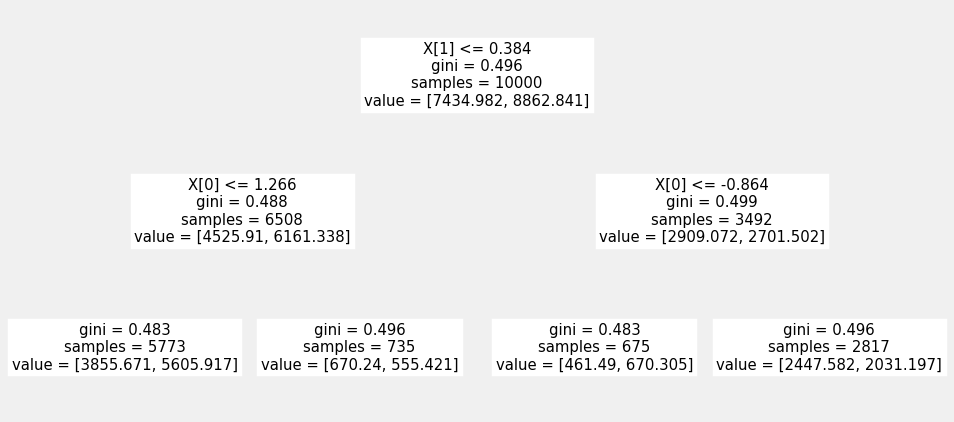

In [11]:
plt.figure(figsize=(15,7))
plot_tree(policy_learner.model_pi)

Alternatively, one can construct a policy directly from the ITE estimated from a X-learner.

In [24]:
learner_x = BaseXRegressor(LGBMRegressor())
ite_x = learner_x.fit_predict(X=X, treatment=W, y=Y)

In this example policy learner outperforms the ITE-based policy and gets close to the true optimal.

In [26]:
pd.DataFrame({
    'DR-DT Optimal': [np.mean((policy_learner.predict(X) + 1) * tt / 2)],
    'True Optimal': [np.mean((np.sign(tt) + 1) * tt / 2)],
    'X Learner': [
        np.mean((np.sign(ite_x) + 1) * tt / 2)
    ],
})

,DR-DT Optimal,True Optimal,X Learner
0,0.169945,0.183291,0.083172
